# Using Python and Julia to apply random algorithms
*by Roberto Esteban López Díaz*

This notebook was wrote with Julia 1.3.1 as the REPL. Python 3.7 is being executed with Julia using the package of PyCall, which can run python functions with the interpreter installed with Anaconda. Check local installation to Python to have the needed libraries.

In [1]:
using PyCall
using Random
using Plots

The random algorithm developed in this notebook is about to compare wheter two polynomials $F(x), G(x)$; in which one is in the canonical form and the other one in its roots format, are equal or not with linear time complexity. This can be achieved as described in [1] page 1, briefly this is done taking a random number $r$ in the interval $\{1,\dots,100d\}$ with uniform probability where $d$ is the degree of the polynomials, and then evaluate both and compare the results. If they are different then the functions are not equal, however if they are the same it could be a mere coincidence of $r$ being a root, for this the experiment is repeated $k$ times, for which a probabilistic bound is given for the chances of the final result of the algorithm to be mistaken when saying the polynomials are the same.

1- Mitzenmacher, M., & Upfal, E. (2017). Probability and computing: Randomization and probabilistic techniques in algorithms and data analysis. Cambridge university press.

In [2]:
function poly_eva(coefs::Array, x::Float64, canon=true)
    r = 0.0
    if canon ### Evaluation form for the coeficients from the canonical form
        for coef in coefs
            r = x * r
            r = coef + r
        end
        else ### Evaluation form for the roots of the polinomial
        r = 1.0
        erste = true 
        for coef in coefs
            if erste ## The first value in this form represents if there's a -1 multiplier.
                erste = false
                continue
            end
            r = r * (x - coef)
        end
        if coefs[1] < 0.0
            r = - r
        end
    end
    return r
end


function rdm_comp(p1::Array, p2::Array, k=6::Int64)
    ## P1 expects the Canonical-form poly oredered in decreasing order of the correponding degree
    ## P2 expects the roots-form poly. In which the first element needs to be 1 if there's not a -1 multiplier or a -1 if there is. 
    ### Both arrays should have the same lenght. 
    ### k is the times the random evaluation is executed, while k is bigger better results will be achieved.
    d = length(p1)
    inter = range(1, stop=100*d)
    if d >= k
        k = d - 1
    end
    e = true
    for i in range(1,stop=k)
        x = convert(Float64, rand(inter))
        f = poly_eva(p1, x)
        g = poly_eva(p2, x, false)
        if !(f ≈ g)
            e = false
            break
        end
    end
    if !e
            return 0
    else
            return 1
    end
end

rdm_comp (generic function with 2 methods)

The following is a loop to evaluate in manual form the algorithm tipying the coeficients and roots manually. Feel free to use the next polinomials.

$x^4+5x^3-20x^2-60x+144 = (x-3)(x-2)(x+4)(x+6)$

In [5]:
while true
    println("Please. Input the canonical form separated with spaces.")
    canon_in = readline()
    canon_ar = split(canon_in, " ")
    d = length(canon_ar)
    println("Please. Input the numbers for the expanded form. Use a 1 or -1 in the begining to give the sign.\n")
    exp_in = readline()
    exp_ar = split(exp_in, " ")
    if length(exp_ar) != d
        println("The expected number of elementes is not equal on the arrays. Please check again")
    else
        canon = Array{Float64,1}(undef,d)
        expanded = Array{Float64,1}(undef,d)

        for i in range(1, stop=d)
            canon[i] = tryparse(Float64, canon_ar[i])
            expanded[i] = tryparse(Float64, exp_ar[i])
        end
        start = time_ns()
        r = rdm_comp(canon,expanded)
        if r == 1
            println("The polynomials are equal.")
        else
            println("The polynomials are different.")
        end
        print("\n",(time_ns()-start)/10^6," ms")
        break
    end
end

Please. Input the canonical form separated with spaces.


stdin>  1 5 -20 -60 144


Please. Input the numbers for the expanded form. Use a 1 or -1 in the begining to give the sign.



stdin>  1 3 2 -4 -6


The polynomials are equal.

0.077488 ms

Now with numpy and its random and poly functions we prepare a set to bench the execution perfomance of the algorithm in julia and python, which is expected to be linear.

In [3]:
py"""
import numpy as np
import numpy.random as rdm

def poly_gen(d):
    p2 = [1]
    p2_ = rdm.choice(1*d+1, d, replace=False).tolist()
    p2 = p2 + p2_
    p1 = np.poly(p2_).tolist()
    return p1, p2

def avg(l):
    return np.mean(l)
"""

In [17]:
average_julia = []
correct = []

for d in range(3,stop=23)
    polys = py"poly_gen"(d)
    i = 1
    c = 0
    t = []
    while i < 1000
        start = time_ns()
        c += rdm_comp(polys[1],polys[2])
        push!(t,(time_ns()-start)/10^6)
        i += 1
    end
    push!(average_julia, py"avg"(t))
    push!(correct, c)
end

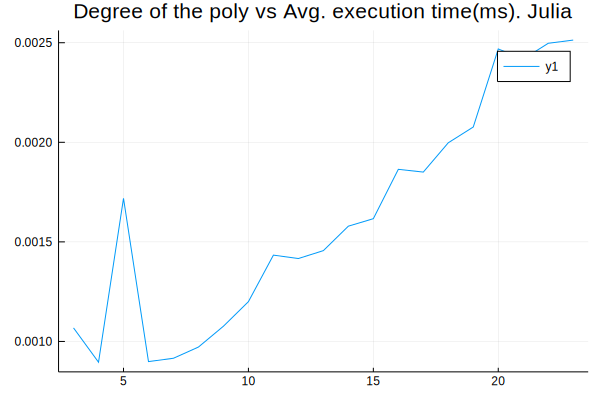

In [18]:
plot(range(3,stop=23), average_julia, title="Degree of the poly vs Avg. execution time(ms). Julia")

These are just the analogous functions on python to evaluate the same.

In [6]:
py"""
import time
import math

def poly_eva(coefs, x, canon = True):
    ## Function to evaluate the polynomials, it returns a float number
    r = 0.0
    if canon:
        for coef in coefs:
            r = x * r
            r = coef + r
        return r
    else:
        r = 1
        for coef in coefs[1:]:
            r = r * (x - coef)
        if coefs[0] < 0:
            r = - r
        return r

def rdm_compr(p1, p2, k=6, bm=True):
    ## P1 expects the Canonical-form poly
    ## P2 expects the roots-form poly
    start = 0
    if not bm: start = time.time()
    # Sampling in the sample space of {1, ..., 100d}
    d = len(p1) - 1 ## Degree of the function, as in canonical form, is the number of coeficients minus 1 (taking into account the 0)
    if d >= k:
        k = d - 1
    e = True ## e turns False if the polynomials get distinct, stays True while is not proven different.
    for _ in range(k):
        x = rdm.randint(1, 100*d+1)
        f = poly_eva(p1, x)
        g = poly_eva(p2, x, False)
        if not math.isclose(f, g):
            e = False 
            break
            
    if not bm:
        if not e:
            print('The polynomials are different.')
            return 0
        else:
            print("The polynomials are equal within an error of %5f" %(1/100**k))
        #tot_time = (time.time()-start)*1000 # in ms
        #print("%.4f ms" % tot_time)
            return 1
    else:
        if e:
            return 1
        else:
            return 0

def tester():
    avr_times = []
    correct = []
    for d in range(3,24):
        p2 = [1]
        p2_ = rdm.choice(1*d+1, d, replace=False).tolist()
        p2 = p2 + p2_
        p1 = np.poly(p2_).tolist()
        i,c,t = 0,0,[]
        while i < 1000:
            start = time.time()
            c += rdm_compr(p1,p2)
            t.append((time.time() - start)*1000) ## in ms
            i += 1
        avr_times.append(np.mean(t))
        correct.append(c)
    return avr_times, correct

"""

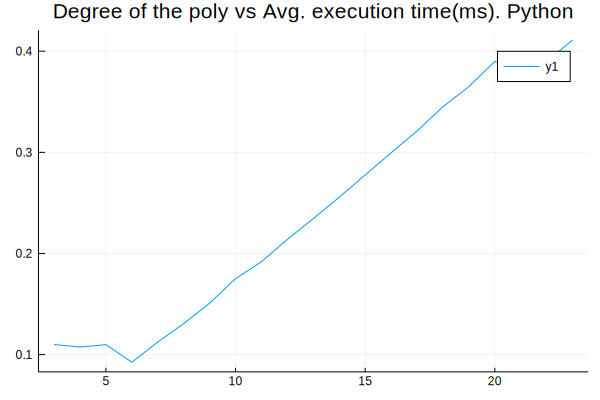

In [7]:
average_python, correct_python = py"tester"()
plot(range(3,stop=23),average_python, title="Degree of the poly vs Avg. execution time(ms). Python")

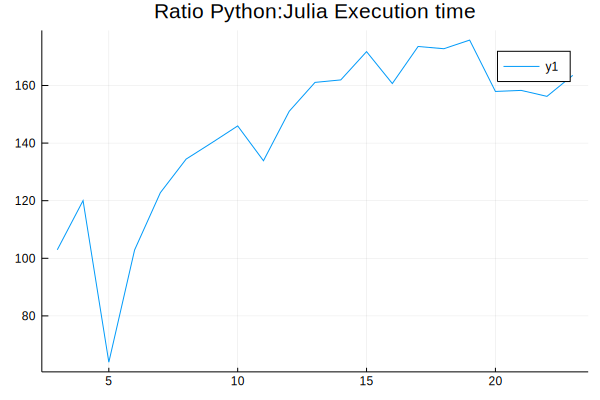

In [19]:
plot(range(3,stop=23), [average_python[x]/average_julia[x] for x in range(1,stop=length(average_python))], title="Ratio Python:Julia Execution time")

In [9]:
### Generating some tests about the precision of the coeficients of the polynomials
p1_100, p2_100 = py"poly_gen"(100)

([1.0, -5049.0, 1.2577026e7, -2.0606194224e10, 2.4977990562756e13, -2.389047086204025e16, 1.8778713961697296e19, -1.2475321097412365e22, 7.149443664481976e24, -3.5900499199481626e27  …  -8.481248239988265e157, 2.035236739689861e158, -4.1506547922960416e158, 7.040830408665472e158, -9.648574118191575e158, 1.0242441183459468e159, -7.885666970408999e158, 3.9079209635636295e158, -9.332621544394422e157, 0.0], [1, 18, 59, 34, 77, 44, 79, 96, 58, 85  …  60, 75, 42, 98, 65, 33, 73, 5, 49, 92])

In [10]:
### Generating some lists for the canonical form
rangos = range(0, 100, step=1.0)
py_poly_canon = [py"poly_eva"(p1_100, x) for x in rangos]
jl_poly_canon = [poly_eva(p1_100, x, true) for x in rangos]

101-element Array{Float64,1}:
  0.0                   
 -9.332621544399912e155 
 -1.4291755081915402e145
 -2.7327494145539604e146
 -1.6101393694676704e147
 -3.785107922927866e148 
  3.8428690510265095e149
 -1.0949389147136102e149
 -3.131339812513076e152 
 -2.4792160688797985e153
 -8.477418396268247e154 
 -3.9065594187510827e155
 -8.391387411029912e156 
  ⋮                     
  3.19158708639046e196  
 -7.474392573024254e196 
 -9.219197730357438e196 
 -5.520637021519109e196 
 -2.206248884597093e197 
 -4.028454035145096e197 
 -1.673249788174037e198 
  6.8333437799976355e196
  5.720950959990015e198 
 -1.9020718254167163e199
  1.1571877277920364e199
 -2.0248671543741277e200

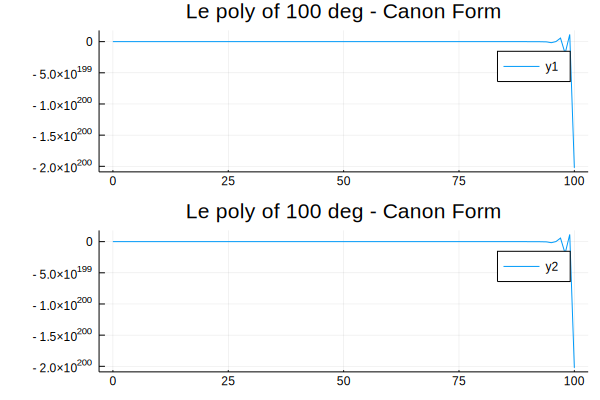

In [16]:
plot(rangos, [py_poly_canon, jl_poly_canon], title="Le poly of 100 deg - Canon Form", layout=(2,1))

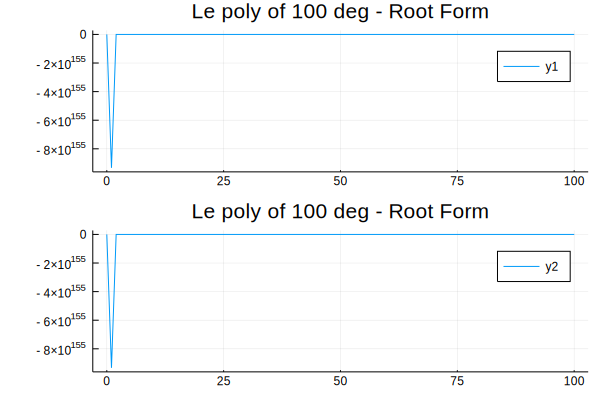

In [15]:
### Generating for the roots form, which is a better more exact way to represent the poly in this method.
### We assume the error is due to the precision of the numbers and how they are represented in the end.
py_poly = [py"poly_eva"(p2_100, x, canon=false) for x in rangos]
jl_poly = [poly_eva(p2_100, x, false) for x in rangos]
plot(rangos, [py_poly, jl_poly], title="Le poly of 100 deg - Root Form", layout=(2,1))

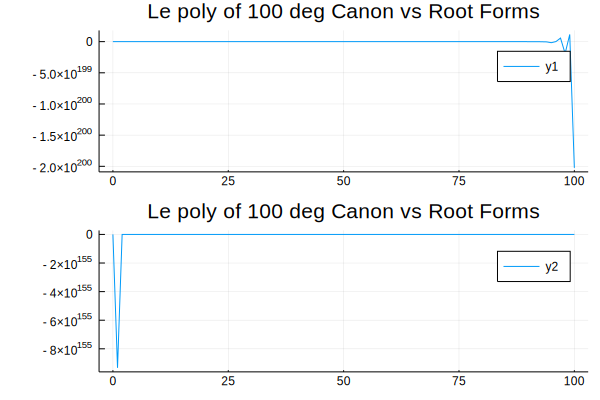

In [14]:
plot(rangos, [py_poly_canon, py_poly], title="Le poly of 100 deg Canon vs Root Forms", layout=(2,1))